In [ ]:
from google.colab import drive
drive.mount('/content/drive')
cifarLink='/content/drive/MyDrive/myProject/Online adversarial attack/CIFAR/cmodel.h5'

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import copy
import tensorflow_hub as hub
import matplotlib
from tensorflow.python.keras import regularizers
from keras.regularizers import l1
from keras.regularizers import l2
from keras.layers import InputLayer
from IPython.display import clear_output 
import os
import distutils
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler


x_train = y_train = x_test = y_test = x_test_copy = None
num_classes = 10
classes=['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
batch_size = 128
epochs = 60
epsilon = 12.5/255
success = 0
shots = 10
alpha = np.exp(-2)
stream_length = 0
select = []
result = None
ground_truth = None
vals = []
arr=None
online = None
mother_result = None
mother_stream = None
mother_ground_truth = None
mother_flag = False
mother_initial_probability = None
mother_friendly_probability = None
mother_real_loss=None
real_loss=None
friendly_probability=None
initial_probability=None
secretary_chosen=[]
hard_chosen=[]
random_success=[]
secretary_success=[]
HLGRatio=[]
LLGRatio=[]
midsuc=0
mlg=0
scale=shift=None
fr=[]
indices=[]
model = None
mistake=[]
indices = []
s = 0
indexMap=[]
hard = 0
friendlyTile=4
adversarialTile=4
reg_strength=1e-4#.005

highest_perturbation=None
lowest_perturbation=None


friendlyEpsilon = 0.3
reg_loss = None

def calcReg(): #other l2
  global reg_loss,model
  reg_loss=0
  print("in calcReg")
  model.summary()
  total=0
  has=0
  for layer in model.layers:
  
    if hasattr(layer, 'kernel_regularizer'):
      total+=1
      if layer.kernel_regularizer is not None:
        l_1=0
        l_2=0

        if hasattr(layer.kernel_regularizer, 'l1'):
          l_1=layer.kernel_regularizer.l1

        if hasattr(layer.kernel_regularizer, 'l2'):
          l_2=layer.kernel_regularizer.l2

        for temp in layer.weights:
          A=np.asarray(temp.numpy())  
          l1_added=np.sum(A)*l_1
          A=np.power(A,2)
          l2_added=np.sum(A)*l_2
          reg_loss=reg_loss+l1_added+l2_added

class element:
    def __init__(self, i, value):
        self.index = i
        self.v = value

    def __ge__(self, other):
        return self.v > other.v

    def __lt__(self, other):
        return self.v < other.v


def testImage(clean_img, adv_image, truth, pred):
    plt.imshow(adv_image - clean_img, cmap='gray', vmin=-epsilon, vmax=1)
    plt.show()



def prepareDataset():
 
    global x_train, y_train, x_test, y_test,x_test_copy

        
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train =tf.keras.utils.to_categorical(y_train,num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test,num_classes=10)

    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    x_test_copy=copy.deepcopy(x_test)

    print("x_train",x_train.shape)
    print("y_train",y_train.shape)
    print("x_test",x_test.shape)
    print("y_test",y_test.shape)
 

def defineModel():
  global x_train, y_train, x_test, y_test,model,scale,shift
 
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  x_train = x_train.astype('float32') / 255
  x_test = x_test.astype('float32') / 255
  x_train_mean = np.mean(x_train, axis=0)
  x_train -= x_train_mean
  x_test -= x_train_mean
  

  num_classes = 10
  y_train = np_utils.to_categorical(y_train,num_classes)
  y_test = np_utils.to_categorical(y_test,num_classes)
  


def trainModel():
    global model
    model= tf.keras.models.load_model('/content/drive/MyDrive/myProject/Online adversarial attack/CIFAR/fullres.h5')
    calcReg()
    print(reg_loss,'reg_loss')        
    model.summary()


def evalModel():
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])


#Vectorized version of attack
def perturb_vect(mode): # other possible mode : friendly,duo. duo is used for speed up and epsilon is used as friendlyEpsilon
  global highest_perturbation,lowest_perturbation
  arr=[]
  label=[]


  for i in range(10000):
    arr.append(x_test[i])
    label.append(y_test[i])
  
  arr=np.asarray(arr)
  label=np.asarray(label)

  length=10000

  cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  perturbation=np.zeros((10000,32,32,3))
 

  highest_loss_found=np.zeros((10000))
  lowest_loss_found=np.ones((10000))*1000
 
 


  if mode=='adversarial':
    highest_perturbation=np.zeros_like(perturbation)
    num=int(32/adversarialTile)

    for layer in range(3):
      for i in range(num):
        for j in range(num):
          print(mode,layer,i,j)
          plus=copy.deepcopy(arr)
          minus=copy.deepcopy(arr)

          plus[:,i*adversarialTile:(i+1)*adversarialTile , j*adversarialTile:(j+1)*adversarialTile,layer]=  plus[:,i*adversarialTile:(i+1)*adversarialTile , j*adversarialTile:(j+1)*adversarialTile,layer]+epsilon
          minus[:,i*adversarialTile:(i+1)*adversarialTile , j*adversarialTile:(j+1)*adversarialTile,layer]=  minus[:,i*adversarialTile:(i+1)*adversarialTile , j*adversarialTile:(j+1)*adversarialTile,layer]-epsilon

          plus=model(plus)
          minus=model(minus)
          
    
         
          plus=cce(label,plus).numpy()
          minus=cce(label,minus).numpy()
          gt=np.squeeze(np.argwhere(plus>minus))
          lt=np.squeeze(np.argwhere(plus<=minus))

          perturbation[gt,i*adversarialTile:(i+1)*adversarialTile , j*adversarialTile:(j+1)*adversarialTile,layer]=epsilon
          arr[gt,i*adversarialTile:(i+1)*adversarialTile , j*adversarialTile:(j+1)*adversarialTile,layer]+=epsilon

          perturbation[lt,i*adversarialTile:(i+1)*adversarialTile , j*adversarialTile:(j+1)*adversarialTile,layer]=-epsilon
          arr[lt,i*adversarialTile:(i+1)*adversarialTile , j*adversarialTile:(j+1)*adversarialTile,layer]-=epsilon

          gt=np.squeeze(np.argwhere(plus>highest_loss_found))
          lt=np.squeeze(np.argwhere(minus>highest_loss_found))

          highest_loss_found[gt]=plus[gt]
          highest_loss_found[lt]=minus[lt]

          highest_perturbation[gt,:,:,:]=perturbation[gt,:,:,:]
          highest_perturbation[lt,:,:,:]=perturbation[lt,:,:,:]

    return highest_perturbation

  elif mode=='friendly':
    lowest_perturbation=np.zeros_like(perturbation)
    num=int(32/friendlyTile)

    for layer in range(3):
      for i in range(num):
        for j in range(num):
          print(mode,layer,i,j)
          plus=copy.deepcopy(arr)
          minus=copy.deepcopy(arr)

       
          plus[:,i*friendlyTile:(i+1)*friendlyTile , j*friendlyTile:(j+1)*friendlyTile,layer]=  plus[:,i*friendlyTile:(i+1)*friendlyTile , j*friendlyTile:(j+1)*friendlyTile,layer]+friendlyEpsilon
          minus[:,i*friendlyTile:(i+1)*friendlyTile , j*friendlyTile:(j+1)*friendlyTile,layer]=  minus[:,i*friendlyTile:(i+1)*friendlyTile , j*friendlyTile:(j+1)*friendlyTile,layer]-friendlyEpsilon

          plus=model(plus)
          minus=model(minus)
          
    
         
          plus=cce(label,plus).numpy()
          minus=cce(label,minus).numpy()
          gt=np.squeeze(np.argwhere(plus<minus))
          lt=np.squeeze(np.argwhere(plus>=minus))

          perturbation[gt,i*friendlyTile:(i+1)*friendlyTile , j*friendlyTile:(j+1)*friendlyTile,layer]=friendlyEpsilon
          arr[gt,i*friendlyTile:(i+1)*friendlyTile , j*friendlyTile:(j+1)*friendlyTile,layer]+=friendlyEpsilon

          perturbation[lt,i*friendlyTile:(i+1)*friendlyTile , j*friendlyTile:(j+1)*friendlyTile,layer]=-friendlyEpsilon
          arr[lt,i*friendlyTile:(i+1)*friendlyTile , j*friendlyTile:(j+1)*friendlyTile,layer]-=friendlyEpsilon

          gt=np.squeeze(np.argwhere(plus<lowest_loss_found))
          lt=np.squeeze(np.argwhere(minus<lowest_loss_found))

          lowest_loss_found[gt]=plus[gt]
          lowest_loss_found[lt]=minus[lt]

          lowest_perturbation[gt,:,:,:]=perturbation[gt,:,:,:]
          lowest_perturbation[lt,:,:,:]=perturbation[lt,:,:,:]

    return lowest_perturbation

  else:
    raise('error. invalid mode')



def perturb_one(idx,mode='adversarial'): # other possible mode : friendly,duo. duo is used for speed up and epsilon is used as friendlyEpsilon

  y=np.expand_dims(y_test[idx],axis=0)
  temp=np.squeeze(x_test[idx])
  x=copy.deepcopy(temp)
  highest_loss_found=None
  lowest_loss_found=None
  highest_perturbation=None
  lowest_perturbation=None

  

  cce = tf.keras.losses.CategoricalCrossentropy()
  perturbation=np.zeros((32,32,3))
  num=int(32/tile)

  if mode=='adversarial':
    for layer in range(3):
      for i in range(num):
        for j in range(num):
          plus=copy.deepcopy(x)
          minus=copy.deepcopy(x)

          plus[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]=  plus[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]+epsilon
          minus[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]=  minus[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]-epsilon


          plus=np.expand_dims(plus,axis=(0))
          minus=np.expand_dims(minus,axis=(0))
          plus=model(plus)
          minus=model(minus)
          plus=cce(y,plus).numpy()
          minus=cce(y,minus).numpy()
          
          if plus>minus:
            perturbation[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]=epsilon
            x[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]+=epsilon

            if highest_loss_found==None or plus>highest_loss_found:
              highest_loss_found=plus
              highest_perturbation=copy.deepcopy(perturbation)



          else:
            perturbation[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]=-epsilon
            x[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]-=epsilon

            if highest_loss_found==None or minus>highest_loss_found:
                highest_loss_found=minus
                highest_perturbation=copy.deepcopy(perturbation)
                

    return highest_perturbation



  elif mode=='friendly':
    for layer in range(3):
      for i in range(num):
        for j in range(num):
          plus=copy.deepcopy(x)
          minus=copy.deepcopy(x)

          plus[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]=  plus[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]+friendlyEpsilon
          minus[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]=  minus[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]-friendlyEpsilon


          plus=np.expand_dims(plus,axis=(0))
          minus=np.expand_dims(minus,axis=(0))
          plus=model(plus)
          minus=model(minus)
          plus=cce(y,plus).numpy()
          minus=cce(y,minus).numpy()
          
          if plus>minus:
            perturbation[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]=-friendlyEpsilon
            x[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]-=friendlyEpsilon

            if lowest_loss_found==None or minus<lowest_loss_found:
              lowest_loss_found=minus
              lowest_perturbation=copy.deepcopy(perturbation)



          else:
            perturbation[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]=friendlyEpsilon
            x[i*tile:(i+1)*tile , j*tile:(j+1)*tile,layer]+=friendlyEpsilon

            if lowest_loss_found==None or plus<lowest_loss_found:
                lowest_loss_found=plus
                lowest_perturbation=copy.deepcopy(perturbation)

    return lowest_perturbation


  else:
      raise Exception("invalid mode")
      

def assess(index,aux=None, metric="Loss"):
    global success
    x = np.expand_dims(x_test[index], axis=0)
    cce = tf.keras.losses.CategoricalCrossentropy()
    y_expanded = np.expand_dims(y_test[index], axis=0)
    y=model(x)
    gt=np.argmax(y_test[index])
    pr=np.argmax(y[0])


    if gt != pr:
      mistake.append(aux)
      return (-1,-1,-1,-1,-1)

 
    initLoss=cce(y_expanded, y).numpy()


    perturbation=perturb(index,mode='adversarial')


    xp = x + perturbation
    
    yp=model(xp)

    apr=np.argmax(yp[0])
    successed = True

    if apr == gt:
        successed = False

    
    loss = cce(y_expanded, y).numpy()
    
   #
    return (loss+reg_loss, successed, initLoss+reg_loss, initLoss+reg_loss,loss)

def generate_stream_data(load):
    global result, ground_truth, mother_result,mistake, mother_stream, mother_ground_truth, mother_flag, mother_initial_probability, mother_friendly_probability,friendly_probability,initial_probability
    global mother_real_loss,real_loss,defsuc,deffail,midsuc,mlg,stream_length,lowest_perturbation,highest_perturbation,arr,indexMap,reg_loss

    lower = 0.6931471824645996
    upper = 2.3025851249694824

    defsuc = 0
    midsuc=0
    deffail = 0

    if mother_flag == False:

      mother_flag = True
      arr=[]
      label=[]


      
      if load==False:

        
        highest_perturbation=perturb_vect('adversarial')

        sl='/content/drive/MyDrive/myProject/Online adversarial attack/CIFAR/ResNeT_highest_pert_'+str(adversarialTile)+'_'+str(epsilon)
        np.save(sl,highest_perturbation) 

    

        lowest_perturbation=perturb_vect('friendly')

        sl='/content/drive/MyDrive/myProject/Online adversarial attack/CIFAR/ResNeT_lowest_pert_'+str(friendlyTile)+'_'+str(friendlyEpsilon)
        np.save(sl,lowest_perturbation)  
        
      elif load==True:
        lowLink='/content/drive/MyDrive/myProject/Online adversarial attack/CIFAR/ResNeT_lowest_pert_'+str(friendlyTile)+'_'+str(friendlyEpsilon)+'.npy'
        highLink='/content/drive/MyDrive/myProject/Online adversarial attack/CIFAR/ResNeT_highest_pert_'+str(adversarialTile)+'_'+str(epsilon)+'.npy'

        lowest_perturbation=np.load(lowLink)
        highest_perturbation=np.load(highLink)

      
      for i in range(10000):
        arr.append(x_test[i])
        label.append(y_test[i])
        indexMap.append(i)
      
      arr=np.asarray(arr)
      indexMap=np.asarray(indexMap)


      label=np.asarray(label)
      init=model(arr)
      mistake=np.not_equal(np.argmax(label,axis=(1)), np.argmax(init,axis=(1)))
      mistake=np.where(mistake)


      cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
     


      arr=np.delete(arr,mistake,axis=(0))
      indexMap=np.delete(indexMap,mistake,axis=(0))
      label=np.delete(label,mistake,axis=(0))
      print("reg_loss is : ",reg_loss)
      
      mother_initial_probability=(cce(label,model(arr))+reg_loss).numpy()
      lowest_perturbation=np.delete(lowest_perturbation,mistake,axis=(0))
      highest_perturbation=np.delete(highest_perturbation,mistake,axis=(0))

      lowest_perturbation=arr+lowest_perturbation
      highest_perturbation=arr+highest_perturbation

     

      predict=model(highest_perturbation)

      mother_ground_truth=(cce(label,model(highest_perturbation))+reg_loss).numpy()
      mother_result=np.not_equal(np.argmax(label,axis=(1)), np.argmax(predict,axis=(1)))
      mother_friendly_probability=(cce(label,model(lowest_perturbation))+reg_loss).numpy()
      mother_real_loss= (mother_ground_truth-reg_loss)


      lower=0.6931471824645996
      upper=2.3025851249694824

      for i in range(mother_real_loss.shape[0]):
        if mother_real_loss[i]>upper:
          defsuc+=1
        
        if mother_real_loss[i] <lower:
          deffail+=1

        
        if mother_real_loss[i]>=lower and mother_real_loss[i]<=upper:
          mlg+=1

          if mother_result[i]:
            midsuc+=1
      
      print("defsuc: ",defsuc)
      print("deffail: ",deffail)
      print("mlg: ",mlg)
      print("midsuc: ",midsuc)


  
   

   
 
      if not (load==True or load==False):
        raise('invalid generation mode')


        
          


    
    idx = np.random.permutation(np.arange(mother_ground_truth.shape[0]))

    result = mother_result[idx]
    ground_truth = mother_ground_truth[idx]
    friendly_probability=mother_friendly_probability[idx]
    initial_probability=mother_initial_probability[idx]
    real_loss=mother_real_loss[idx]




def onlineAttack(verbose=False):
  global ground_truth,vals,s,indices,hard,initial_probability,friendly_probability,stream_length
  t=int(alpha*stream_length)
  R=[]
  choosen_sum=0
  indices=[]
  vals=[]
  hard=0

  lower=0.6931471824645996
  upper=2.3025851249694824
  remainedShots=shots
  best_estimated_regularization=1000000
  stream_length=mother_ground_truth.shape[0]


  for i in range(stream_length):


      best_estimated_regularization=min(friendly_probability[i],initial_probability[i],best_estimated_regularization)
      
      ground_truth[i]=ground_truth[i]-best_estimated_regularization

    

      if verbose:
        print("best estimation : ",best_estimated_regularization," current friendly loss : ",friendly_probability[i]," current ce loss : ",ground_truth[i]," init probability : ",initial_probability[i],"real loss : ",real_loss[i])
  

  for i in range (t):
    if len(indices)>=shots:
      break
    if ground_truth[i]<lower:

      continue
    if ground_truth[i]>upper:
      hard+=1
      remainedShots-=1
      indices.append(i)

      while len(R)>remainedShots:
        R.pop(0)
        
        

      continue

    if len(R)<remainedShots:
      R.append(ground_truth[i])

    elif len(R)==remainedShots:
      R.sort()

    else:
      if ground_truth[i]>R[0]:
        R[0]=ground_truth[i]
        R.sort()
  

  for i in range(t,stream_length):
    if len(indices)>=shots:
      break

    if ground_truth[i]<lower:
      continue

    if ground_truth[i]>upper: 
      indices.append(i)
      remainedShots-=1
      hard+=1
      while len(R)>remainedShots and len(R)>0:
        R.pop(0)
        ("pre len(R)=",len(R),"len(indices):",len(indices))
      continue
    

   
    if len(R)>0 and ground_truth[i]>R[0]:
      #print("i is : ",i,"and len(R)=",len(R),"len gt :",ground_truth.shape)
      indices.append(i)
        
      if len(R)==remainedShots:
        R[0]=copy.deepcopy(ground_truth[i])

      else:
        R.append(copy.deepcopy(ground_truth[i]))

      choosen_sum+=R[0]
      vals.append(copy.deepcopy(R[0]))
      R.sort()
      continue

    if len(R)==0:
      indices.append(i)
      R.append(copy.deepcopy(ground_truth[i]))
      choosen_sum+=R[0]
      vals.append(copy.deepcopy(R[0]))


    
    if stream_length-i == shots - len(indices):
      for j in range (i,stream_length):
        if ground_truth[j]<lower:
          continue
        indices.append(j)
        vals.append(copy.deepcopy(ground_truth[j]))
        choosen_sum+=ground_truth[j]
      break

  s=0

  for i in indices:
    if result[i]:
      s+=1
  
  hard_chosen.append(hard)
  secretary_chosen.append(len(indices)-hard)
  
  fr.append(s/shots)



fool_rate=[]
success_avg=[]
success_std=[]
fail_avg=[]
fail_std=[]
total_avg=[]
total_std=[] 



def plot(show=False):
  global result,ground_truth,vals,hard,indices,hard_chosen,secretary_chosen,secretary_success,fr,real_loss,HLGRatio,MLGRatio
  lower=0.6931471824645996
  upper=2.3025851249694824
  mlg_success=0

  for i in indices:
   
  
    if ground_truth[i]<= upper and ground_truth[i]>=lower and result[i] :
      mlg_success+=1

  if secretary_chosen[-1]>0:
    secretary_success.append(mlg_success/secretary_chosen[-1])

  mysuc=0
  myfail=0

  for i in range(stream_length):
    if ground_truth[i]>=upper:
      mysuc+=1
    
    if ground_truth[i]<=lower:
      myfail+=1

  HLGRatio.append(mysuc)
  LLGRatio.append(myfail)
      


def randomSelectionInMLG():
  mlg=0
  success=0
  lower=0.6931471824645996
  upper=2.3025851249694824

  for i in range(stream_length):
     if ground_truth[i]<= upper and ground_truth[i]>=lower:
       mlg+=1

       if result[i]:
         success+=1
  
  return success/mlg


def randomSelectionNotKnowingM():
  total=0
  success=0
  lower=0.6931471824645996
  upper=2.3025851249694824

  for i in range(stream_length):
     if ground_truth[i]>=lower:
       total+=1
       
       if result[i]:
         success+=1


  return success/total



#########################################################################################################################
#########################################################################################################################
#########################################################################################################################
#########################################################################################################################

prepareDataset()
defineModel()
trainModel()
evalModel()
generate_stream_data(False)
onlineAttack()

x_train (50000, 32, 32, 3)
y_train (50000, 10)
x_test (10000, 32, 32, 3)
y_test (10000, 10)
in calcReg
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]

In [ ]:
bookmark=0
hard_chosen=[]
secretary_chosen=[]
secretary_success=[]
fr=[]
shots=10
iter=1000


for i in range(iter):

  generate_stream_data(True)
  onlineAttack()
  plot()


generate_stream_data(True)
onlineAttack(True)

fr=np.asarray(fr, dtype=np.float32)
secretary_success=np.asarray(secretary_success, dtype=np.float32)

secretary_chosen=np.asarray(secretary_chosen, dtype=np.float32)
hard_chosen=np.asarray(hard_chosen, dtype=np.float32)

print("These are general results yielded for ",iter," number of random permutations")
print("average fool rate under my assumption : ",np.mean(fr))

print("average success for secretary chosen data : ",np.mean(secretary_success))
print("average number of data chosen by secretary : ",np.mean(secretary_chosen))
print("average number of hard chosen data : ",np.mean(hard_chosen))
print("average number of selected data : ",np.mean(hard_chosen+secretary_chosen))
print("random MLG success rate : ",randomSelectionInMLG())
print("random choice not knowing m success rate : ",randomSelectionNotKnowingM())
print("mean HLG grouped : ",np.mean(np.asarray(HLGRatio)))
print("mean LLG grouped : ",np.mean(np.asarray(LLGRatio)))


hard_chosen=[]
secretary_chosen=[]

secretary_success=[]
fr=[]


print(np.amax(mother_friendly_probability))
print(np.amax(mother_initial_probability))




def plotShots():
  
  for i in indices:
    x= np.expand_dims(x_test[i], axis=0)
    yc=model(x)
    perturbation=fgsm(epsilon,i)
    print("perturbation shape ",perturbation.shape)
    print("x",x.shape)
    perturbation=np.expand_dims(perturbation,axis=(0,-1))
    xp=np.squeeze(perturbation)+np.squeeze(x)
    xp=np.expand_dims(xp,axis=(0,-1))
  
    yp=model(xp)

    if (np.argmax(yc)!=np.argmax(yp)) and (result[i] != -1):
      testImage(np.squeeze(x),np.squeeze(xp),np.argmax(yc),np.argmax(yp))

#plotShots()



Streaming output truncated to the last 5000 lines.
best estimation :  0.12224824  current friendly loss :  0.1222486  current ce loss :  0.5151876  init probability :  0.12224848 real loss :  0.5151876
best estimation :  0.12224824  current friendly loss :  0.12224824  current ce loss :  18.774193  init probability :  0.12224848 real loss :  18.774193
best estimation :  0.12224824  current friendly loss :  0.12224824  current ce loss :  15.598349  init probability :  0.12881331 real loss :  15.598349
best estimation :  0.12224824  current friendly loss :  0.12224824  current ce loss :  15.482643  init probability :  0.12224872 real loss :  15.482643
best estimation :  0.12224824  current friendly loss :  0.12224824  current ce loss :  0.0  init probability :  0.12224824 real loss :  0.0
best estimation :  0.12224824  current friendly loss :  0.12224824  current ce loss :  25.355198  init probability :  0.12224848 real loss :  25.355198
best estimation :  0.12224824  current friendly lo

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
hard_chosen=[]
secretary_chosen=[]
secretary_success=[]
fr=[]
shots=100
iter=1000


for i in range(iter):

  generate_stream_data(True)
  onlineAttack()
  plot()



fr=np.asarray(fr, dtype=np.float32)
secretary_success=np.asarray(secretary_success, dtype=np.float32)

secretary_chosen=np.asarray(secretary_chosen, dtype=np.float32)
hard_chosen=np.asarray(hard_chosen, dtype=np.float32)

print("These are general results yielded for ",iter," number of random permutations")
print("average fool rate under my assumption : ",np.mean(fr))

print("average success for secretary chosen data : ",np.mean(secretary_success))
print("average number of data chosen by secretary : ",np.mean(secretary_chosen))
print("average number of hard chosen data : ",np.mean(hard_chosen))
print("average number of selected data : ",np.mean(hard_chosen+secretary_chosen))
print("random MLG success rate : ",randomSelectionInMLG())
print("random choice not knowing m success rate : ",randomSelectionNotKnowingM())
print("mean HLG grouped : ",np.mean(np.asarray(HLGRatio)))
print("mean LLG grouped : ",np.mean(np.asarray(LLGRatio)))


hard_chosen=[]
secretary_chosen=[]

secretary_success=[]
fr=[]





def plotShots():
  
  for i in indices:
    x= np.expand_dims(x_test[i], axis=0)
    yc=model(x)
    perturbation=fgsm(epsilon,i)
    print("perturbation shape ",perturbation.shape)
    print("x",x.shape)
    perturbation=np.expand_dims(perturbation,axis=(0,-1))
    xp=np.squeeze(perturbation)+np.squeeze(x)
    xp=np.expand_dims(xp,axis=(0,-1))
  
    yp=model(xp)

    if (np.argmax(yc)!=np.argmax(yp)) and (result[i] != -1):
      testImage(np.squeeze(x),np.squeeze(xp),np.argmax(yc),np.argmax(yp))

#plotShots()



These are general results yielded for  1000  number of random permutations
average fool rate under my assumption :  1.0
average success for secretary chosen data :  nan
average number of data chosen by secretary :  0.0
average number of hard chosen data :  100.0
average number of selected data :  100.0
random MLG success rate :  0.9846153846153847
random choice not knowing m success rate :  0.9998788319399007
mean HLG grouped :  8188.0
mean LLG grouped :  917.0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
hard_chosen=[]
secretary_chosen=[]
secretary_success=[]
fr=[]
shots=1000
iter=2000


for i in range(iter):

  generate_stream_data(True)
  onlineAttack()
  plot()



fr=np.asarray(fr, dtype=np.float32)
secretary_success=np.asarray(secretary_success, dtype=np.float32)

secretary_chosen=np.asarray(secretary_chosen, dtype=np.float32)
hard_chosen=np.asarray(hard_chosen, dtype=np.float32)

print("These are general results yielded for ",iter," number of random permutations")
print("average fool rate under my assumption : ",np.mean(fr))

print("average success for secretary chosen data : ",np.mean(secretary_success))
print("average number of data chosen by secretary : ",np.mean(secretary_chosen))
print("average number of hard chosen data : ",np.mean(hard_chosen))
print("average number of selected data : ",np.mean(hard_chosen+secretary_chosen))
print("random MLG success rate : ",randomSelectionInMLG())
print("random choice not knowing m success rate : ",randomSelectionNotKnowingM())
print("mean HLG grouped : ",np.mean(np.asarray(HLGRatio)))
print("mean LLG grouped : ",np.mean(np.asarray(LLGRatio)))


hard_chosen=[]
secretary_chosen=[]

secretary_success=[]
fr=[]





def plotShots():
  
  for i in indices:
    x= np.expand_dims(x_test[i], axis=0)
    yc=model(x)
    perturbation=fgsm(epsilon,i)
    print("perturbation shape ",perturbation.shape)
    print("x",x.shape)
    perturbation=np.expand_dims(perturbation,axis=(0,-1))
    xp=np.squeeze(perturbation)+np.squeeze(x)
    xp=np.expand_dims(xp,axis=(0,-1))
  
    yp=model(xp)

    if (np.argmax(yc)!=np.argmax(yp)) and (result[i] != -1):
      testImage(np.squeeze(x),np.squeeze(xp),np.argmax(yc),np.argmax(yp))

#plotShots()



These are general results yielded for  2000  number of random permutations
average fool rate under my assumption :  1.0
average success for secretary chosen data :  nan
average number of data chosen by secretary :  0.0
average number of hard chosen data :  1000.0
average number of selected data :  1000.0
random MLG success rate :  0.9846153846153847
random choice not knowing m success rate :  0.9998788319399007
mean HLG grouped :  8188.0
mean LLG grouped :  917.0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


class  0


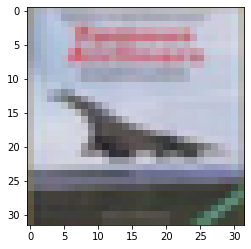

class  1


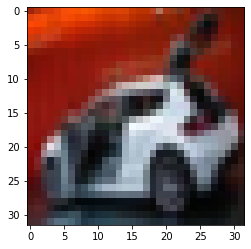

class  2


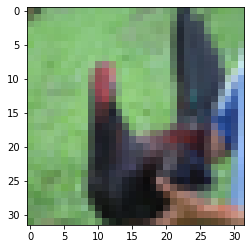

class  3


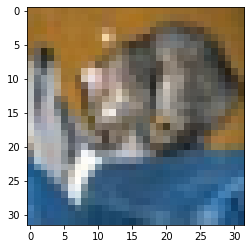

class  4


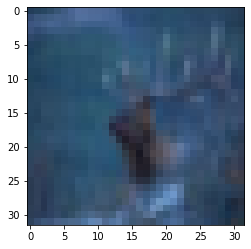

class  5


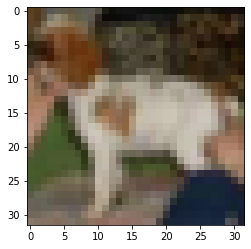

class  6


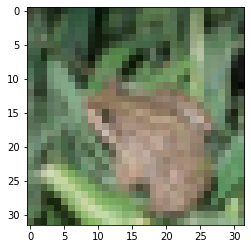

class  7


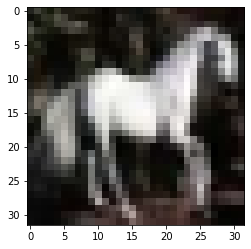

class  8


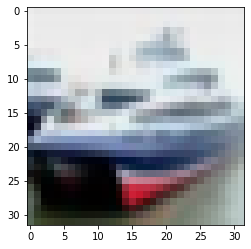

class  9


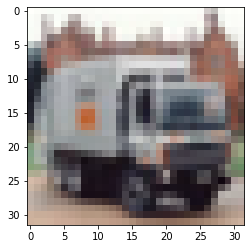

In [ ]:
for i in range(10):
  for j in range(10000):
    # print(y_test[j])
    # print(np.argmax(y_test[j]))
    if np.argmax(y_test[j])==i:
      print("class ",i)
      plt.imshow(x_test_copy[j])
      plt.show()
      break
      print("\n\n") 
classes=['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
